# TS Clustering Project

William Gilmore

In [26]:
#import necessary packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from datetime import date
import warnings 
import glob
#SciKit

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Warnings
warnings.simplefilter('ignore') 

#load map packages
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from calendar import month_abbr


## Functions

Compile Function

In [2]:
#Author: Paul
#compiles all voyages

#I've changed all instances of "sail to ds" and changed ddir to be a relative file path -will
def Compile_Datasets(fn_list_in):


    # fn_list_in: list of strings with the file names, or filename(string), or "all"
    # returns: compiled list
    fn_list = []
    
    ddir = "../saildrone_data"
    
    # Make sure the fn_list_in is formatted correctly
    if(fn_list_in == "all"):
        
        fn_list = glob.glob(ddir+ '/*.nc')
    elif(type(fn_list_in) == 'list' and type(fn_list_in[0]) == 'string'):
        fn_list = fn_list_in
    elif(type(fn_list_in) == 'string'):
        fn_list[0] = fn_list_in
    else: 
        raise Exception("first argument to 'Compile_Data_Set_And_Graph' function must be; a list of file names, a file name, or \"all\"")
        
    print()
    
    # open the first dataset
    sail = xr.open_dataset(fn_list[0])
    
    sail = sail.drop_vars("trajectory", errors='ignore')
    
    # give the first dataset a relative ID so all datasets can be differentiated
    sail["relativeID"] = 0
    # make lists for certain variables that remain constant for each dataset. these are used later in the last two cells
    yearList = [sail["time"][0].dt.year]
    durationList = [sail["time"][len(sail["time"]) - 1] - sail["time"][0]]
    # take the actual cruise ID from the dataset attributes and put it in a new list
    try:
        realID = [int(sail.attrs["id"])]
    except:
        realID = [fn_list[0]]
    sail["realID"] = realID[0]
    # add the duration back to the dataset
    sail["duration"] = durationList[0]

    # repeat previous steps for other datasets that need to be combined.

    if len(fn_list) > 1:
        for i in range(1, len(fn_list)):
            temp = xr.open_dataset(fn_list[i])
            temp = temp.drop_vars("trajectory", errors='ignore')
            temp["relativeID"] = i
            yearList.append(temp["time"][0].dt.year)
            
            try:
                realID.append(int(temp.attrs["id"]))
            except:
                realID.append(fn_list[i])
                
            tempDuration = temp["time"][len(temp["time"]) - 1] - temp["time"][0]
            temp["duration"] = tempDuration
            durationList.append(tempDuration)
            temp["realID"] = realID[i]
            sail = xr.concat([sail, temp], dim="time")
            temp.close()

    # reformat dates
    sail['date'] = mdates.date2num(sail['time'].dt.date)

    # ask what variable should be plotted
    return(sail)

West Coast Selection Function

In [3]:
#Author: William Gilmore
#Isolates data on the westcoast
def westcoast(upperLat, lowerLat):
    
    #upperLat: Upper acceptable latitude
    #lowerLat: Lower acceptable latitude
    # -function will discard all data not between upperLat and lowerLat
    
    # Runs Pauls function to gather all saildrone data into 1 dataset
    ds = Compile_Datasets("all")
    
    #Removes Data outside of Westcoast
    ds = ds.where((ds.lon > -130) & (ds.lon < -115) & (ds.lat > 27) & (ds.lat < 52))
    
    #Removes data that is not within 300 km of shore
    ds = ds.where(ds.dist_land <= 300)
    
    #Removes SF bay data
    ds = ds.where(~(((ds.lon > -122.5938) & (ds.lat > 37.72783)) & ((ds.lon < -122.2506620424831) & (ds.lat < 38.094658646550556))) | ~(((ds.lon > -122.38678630116495) & (ds.lat > 37.430464705762226)) & ((ds.lon < -121.99799777841487) & (ds.lat < 37.81408437558721))))
    
    #Removes Data not between upperLat and lowerLat
    ds = ds.where((ds.lat > lowerLat) & (ds.lat < upperLat))
     

    return(ds)

## Access and Filter Data

Function Calls

In [4]:
ds = westcoast(50, 20)

## Kmeans

In [5]:
#check with solamon to see if there was any reason for it to be 32 initially.
#filter out salinity values that are less than or equal to 31
ds['SAL_CTD_MEAN']=ds.SAL_CTD_MEAN.where(ds.SAL_CTD_MEAN>=31, np.nan)

In [6]:
#converts data from xarray.Dataset to array of (temp, sal) points and drops all nans

ds2 = ds[['TEMP_CTD_MEAN', 'SAL_CTD_MEAN']].to_dataframe()
ds3 = ds2.dropna()
sal = ds3.SAL_CTD_MEAN.values
temp = ds3.TEMP_CTD_MEAN.values

ds3 = ds3.drop('ob', axis = 1)

ds4 = ds3.values

ds4
#error is from temp and sal not being equal lenghts

array([[16.63336627, 32.26855529],
       [16.21376491, 32.37186873],
       [13.54144207, 32.61179498],
       ...,
       [16.08148718, 32.15194872],
       [15.3531913 , 32.11461304],
       [15.08320558, 31.36533333]])

In [7]:
#feature scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(ds4)
scaled_features

array([[0.57358473, 0.40789777],
       [0.54077838, 0.44127262],
       [0.33184399, 0.51877949],
       ...,
       [0.53043631, 0.37022865],
       [0.47349481, 0.35816757],
       [0.45238609, 0.11611682]])

In [32]:

# create kmeans object
kmeans = KMeans(init="random", n_clusters=6, n_init=10, max_iter=300, random_state=42)
# fit kmeans object to data
kmeans.fit(scaled_features)

# save new clusters for chart
#y_km = kmeans.fit(ds)

#assigns each point to a cluster 
labels = kmeans.labels_


In [33]:
#Reverse Scaling

#Changes the centroids from being scaled to being the real (temp, sal) data
inverted_scaled_centroids = scaler.inverse_transform(kmeans.cluster_centers_)

### Normal Graph

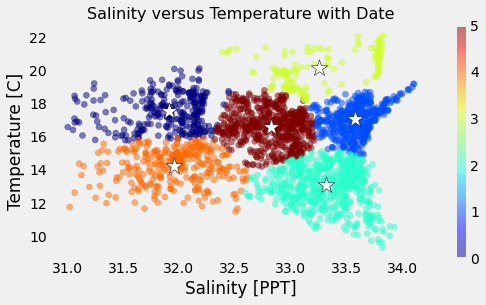

In [34]:
fig = plt.figure(figsize=(7.6,4)) 


#plots data points
sc = plt.scatter(x = ds4[:, 1], y = ds4[:, 0], c = labels, cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc)

#plots Centroids
plt.scatter(
    inverted_scaled_centroids[:, 1], inverted_scaled_centroids[:, 0],
   s=300, marker='*',
    c='white', edgecolor='black',
    label='centroids'
)

#window dressing
plt.title('Salinity versus Temperature with Date', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
plt.grid()



plt.show()

### Scaled Graph

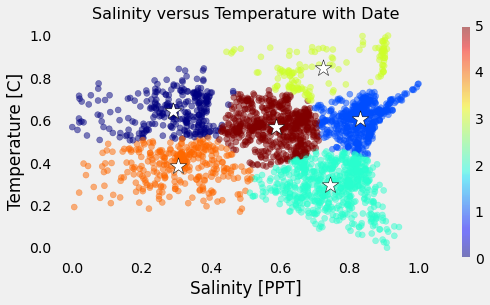

In [35]:
fig = plt.figure(figsize=(7.6,4)) 

#plots data points
sc = plt.scatter(x = scaled_features[:, 1], y = scaled_features[:, 0], c = labels, cmap='jet', alpha = 0.5)
clb = fig.colorbar(sc)

#plots Centroids
plt.scatter(
    kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0],
    s=300, marker='*',
    c='white', edgecolor='black',
    label='centroids'
)

#window dressing
plt.title('Salinity versus Temperature with Date', fontdict = {'fontsize' : 16})
plt.xlabel("Salinity [PPT]")
plt.ylabel("Temperature [C]")
plt.grid()



plt.show()

## Elbow Method

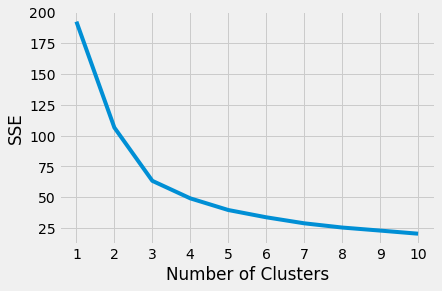

In [24]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    

    
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Elbow appears to be at 3

## Silhouette Coefficiente

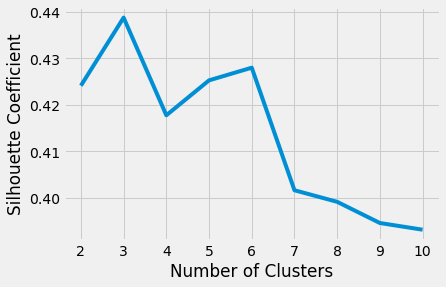

In [27]:
In [17]: # A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

#### 3 Clusters has the maximum score but something interesting is happening at 6 clusters so that will be investigated as well

#### More advanced methods of optimal cluster analysis rely on ground truth labels which we dont currently have for this dataset.